# Big Mart Sale Forecast

## Importing Necessary Modules/Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

## Loading the Datasets

In [2]:
train = pd.read_csv('train.csv')

In [3]:
train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136


In [4]:
train['Item_Identifier'].value_counts()

Item_Identifier
FDW13    10
FDG33    10
FDX31     9
FDT07     9
NCY18     9
         ..
FDO33     1
FDK57     1
FDT35     1
FDN52     1
FDE52     1
Name: count, Length: 1559, dtype: int64

In [5]:
train['Item_Identifier'].value_counts().shape

(1559,)

In [6]:
test = pd.read_csv('test.csv')

In [7]:
test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3
...,...,...,...,...,...,...,...,...,...,...,...
5676,FDB58,10.500,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1
5677,FDD47,7.600,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2
5678,NCO17,10.000,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1
5679,FDJ26,15.300,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1


In [8]:
target = train['Item_Outlet_Sales']
train.drop(columns='Item_Outlet_Sales',inplace=True)

In [9]:
train['Source'] = 'train'
test['Source'] = 'test'

In [10]:
df = pd.concat([train,test],ignore_index=True)

In [11]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,train
...,...,...,...,...,...,...,...,...,...,...,...,...
14198,FDB58,10.50,Regular,0.013496,Snack Foods,141.3154,OUT046,1997,Small,Tier 1,Supermarket Type1,test
14199,FDD47,7.60,Regular,0.142991,Starchy Foods,169.1448,OUT018,2009,Medium,Tier 3,Supermarket Type2,test
14200,NCO17,10.00,Low Fat,0.073529,Health and Hygiene,118.7440,OUT045,2002,NaN,Tier 2,Supermarket Type1,test
14201,FDJ26,15.30,Regular,0.000000,Canned,214.6218,OUT017,2007,NaN,Tier 2,Supermarket Type1,test


## Investigating the Dataframe

In [12]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,11764.000000,14203.000000,14203.000000,14203.000000
mean,12.792684,0.065954,141.009592,1997.830740
std,4.652663,0.051460,62.086688,8.371956
min,4.555000,0.000000,31.290000,1985.000000
25%,8.710000,0.027035,94.027800,1987.000000
50%,12.600000,0.054026,142.247000,1999.000000
75%,16.750000,0.094037,185.855600,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14203 entries, 0 to 14202
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14203 non-null  object 
 1   Item_Weight                11764 non-null  float64
 2   Item_Fat_Content           14203 non-null  object 
 3   Item_Visibility            14203 non-null  float64
 4   Item_Type                  14203 non-null  object 
 5   Item_MRP                   14203 non-null  float64
 6   Outlet_Identifier          14203 non-null  object 
 7   Outlet_Establishment_Year  14203 non-null  int64  
 8   Outlet_Size                10187 non-null  object 
 9   Outlet_Location_Type       14203 non-null  object 
 10  Outlet_Type                14203 non-null  object 
 11  Source                     14203 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.3+ MB


In [14]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Source                          0
dtype: int64

## Handling the Missing Values

In [15]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)

In [16]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Source                          0
dtype: int64

In [17]:
mode = df.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=lambda x : x.mode()[0])

In [18]:
mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [19]:
missing_values = df['Outlet_Size'].isnull()

In [20]:
missing_values.value_counts()

Outlet_Size
False    10187
True      4016
Name: count, dtype: int64

In [21]:
df.loc[missing_values,'Outlet_Size']=df.loc[missing_values,'Outlet_Type'].apply(lambda x : mode[x])

In [22]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Source                       0
dtype: int64

In [23]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,14203.000000,14203.000000,14203.000000,14203.000000
mean,12.792684,0.065954,141.009592,1997.830740
std,4.234342,0.051460,62.086688,8.371956
min,4.555000,0.000000,31.290000,1985.000000
25%,9.300000,0.027035,94.027800,1987.000000
50%,12.792684,0.054026,142.247000,1999.000000
75%,16.000000,0.094037,185.855600,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


## Exploratory Data Analysis

In [24]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Source'],
      dtype='object')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14203 entries, 0 to 14202
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            14203 non-null  object 
 1   Item_Weight                14203 non-null  float64
 2   Item_Fat_Content           14203 non-null  object 
 3   Item_Visibility            14203 non-null  float64
 4   Item_Type                  14203 non-null  object 
 5   Item_MRP                   14203 non-null  float64
 6   Outlet_Identifier          14203 non-null  object 
 7   Outlet_Establishment_Year  14203 non-null  int64  
 8   Outlet_Size                14203 non-null  object 
 9   Outlet_Location_Type       14203 non-null  object 
 10  Outlet_Type                14203 non-null  object 
 11  Source                     14203 non-null  object 
dtypes: float64(3), int64(1), object(8)
memory usage: 1.3+ MB


In [26]:
numeric_df = df.select_dtypes(include='number')
num_cols=list(numeric_df.columns)
num_cols

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

In [27]:
object_df = df.select_dtypes(include='object')
obj_cols=list(object_df.columns)
obj_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Source']

### Numeric EDA

#### 1. Summary Statistics

In [28]:
def numeric_summary(df, num_cols):
    return df[num_cols].describe()

In [29]:
numeric_summary(df, num_cols)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,14203.000000,14203.000000,14203.000000,14203.000000
mean,12.792684,0.065954,141.009592,1997.830740
std,4.234342,0.051460,62.086688,8.371956
min,4.555000,0.000000,31.290000,1985.000000
25%,9.300000,0.027035,94.027800,1987.000000
50%,12.792684,0.054026,142.247000,1999.000000
75%,16.000000,0.094037,185.855600,2004.000000
max,21.350000,0.328391,266.888400,2009.000000


#### 2. Distribution Plots (Histograms)

In [30]:
def plot_numeric_distributions(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.show()

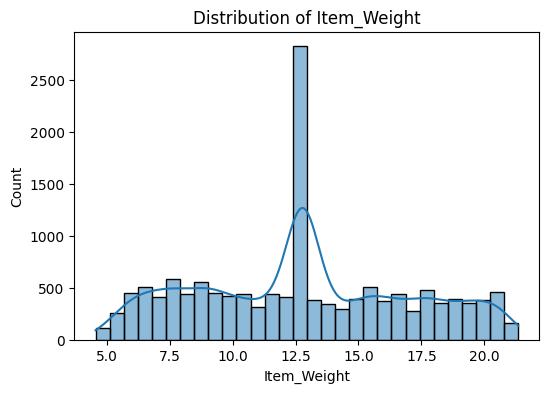

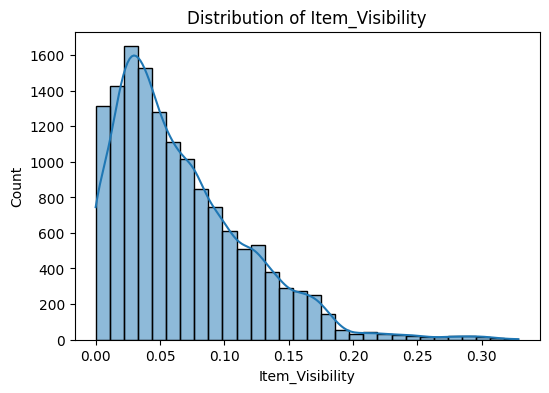

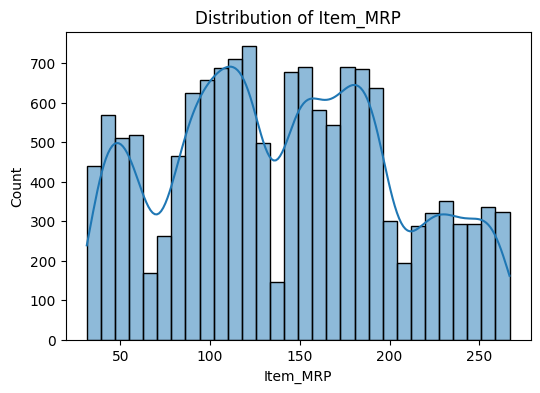

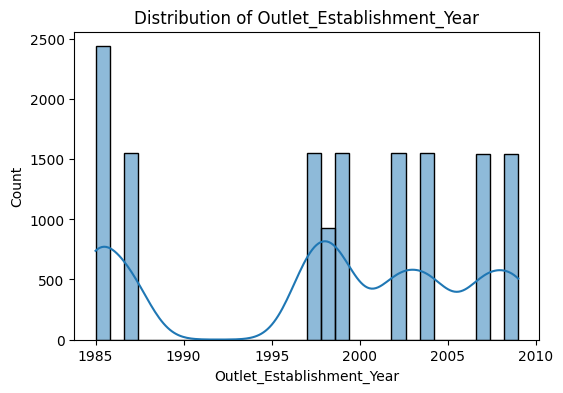

In [31]:
plot_numeric_distributions(df, num_cols)

#### 3. Boxplots for Outliers

In [32]:
def plot_numeric_boxplots(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

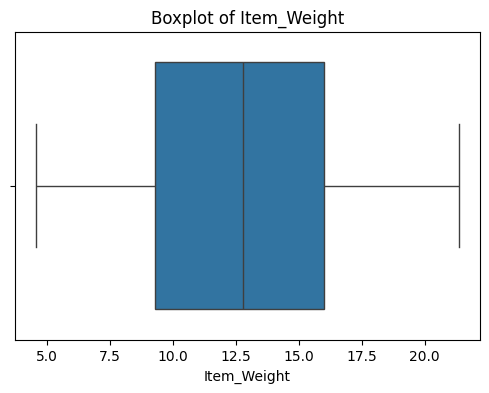

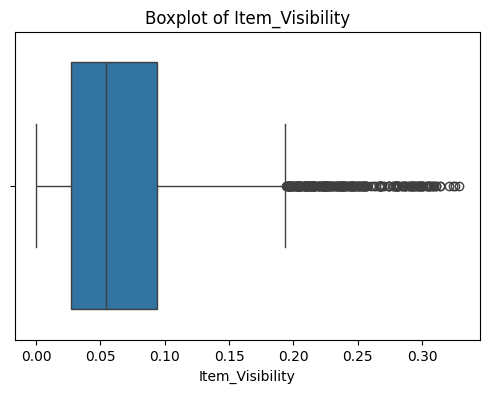

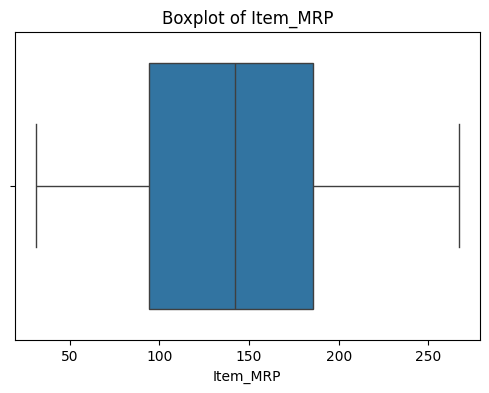

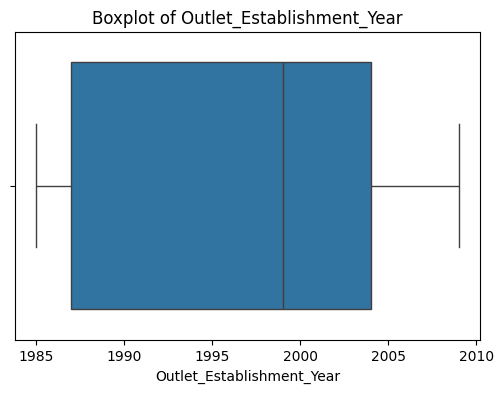

In [33]:
plot_numeric_boxplots(df, num_cols)

#### 4. Correlation Heatmap

In [34]:
def correlation_heatmap(df, num_cols):
    plt.figure(figsize=(8, 6))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

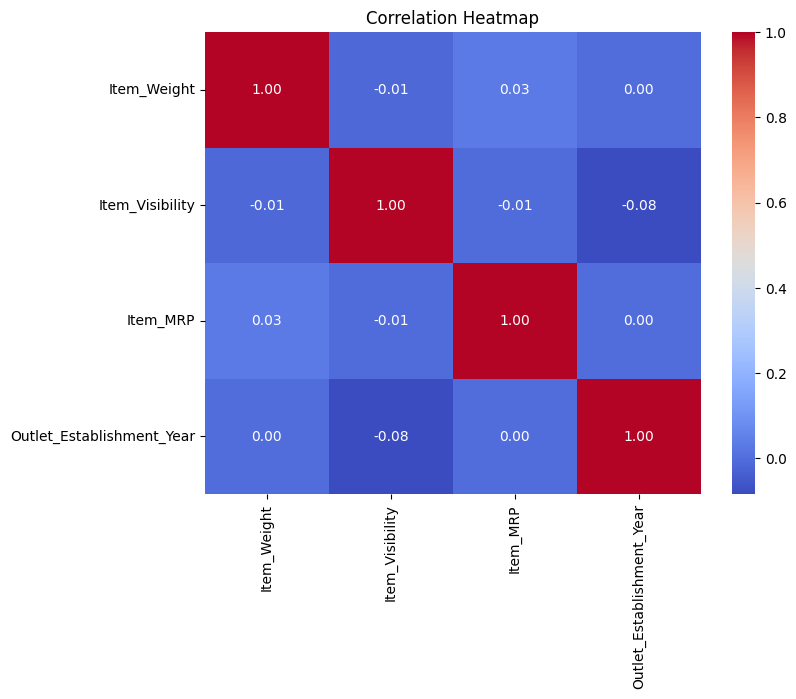

In [35]:
correlation_heatmap(df, num_cols)

### Categorical EDA

#### 1. Value Counts Summary

In [36]:
def categorical_summary_combined(df, obj_cols):
    all_counts = []
    for col in obj_cols:
        vc = df[col].value_counts(dropna=False).reset_index()
        vc.columns = ['Category', 'Count']
        vc['Column'] = col
        all_counts.append(vc)
    return pd.concat(all_counts, ignore_index=True)

In [37]:
combined_summary = categorical_summary_combined(df, obj_cols)
combined_summary

,Category,Count,Column
0,FDX13,10,Item_Identifier
1,NCU29,10,Item_Identifier
2,FDP21,10,Item_Identifier
3,NCT53,10,Item_Identifier
4,NCS29,10,Item_Identifier
...,...,...,...
1597,Grocery Store,1805,Outlet_Type
1598,Supermarket Type3,1559,Outlet_Type
1599,Supermarket Type2,1546,Outlet_Type
1600,train,8522,Source


#### 2. Bar Plots

In [38]:
def plot_categorical_counts(df, obj_cols):
    for col in obj_cols:
        if col != 'Item_Identifier' and col != 'Source':
            plt.figure(figsize=(21, 7))
            sns.countplot(x=df[col], order=df[col].value_counts().index)
            plt.title(f'Count plot of {col}')
            plt.xticks(rotation=45)
            plt.show()

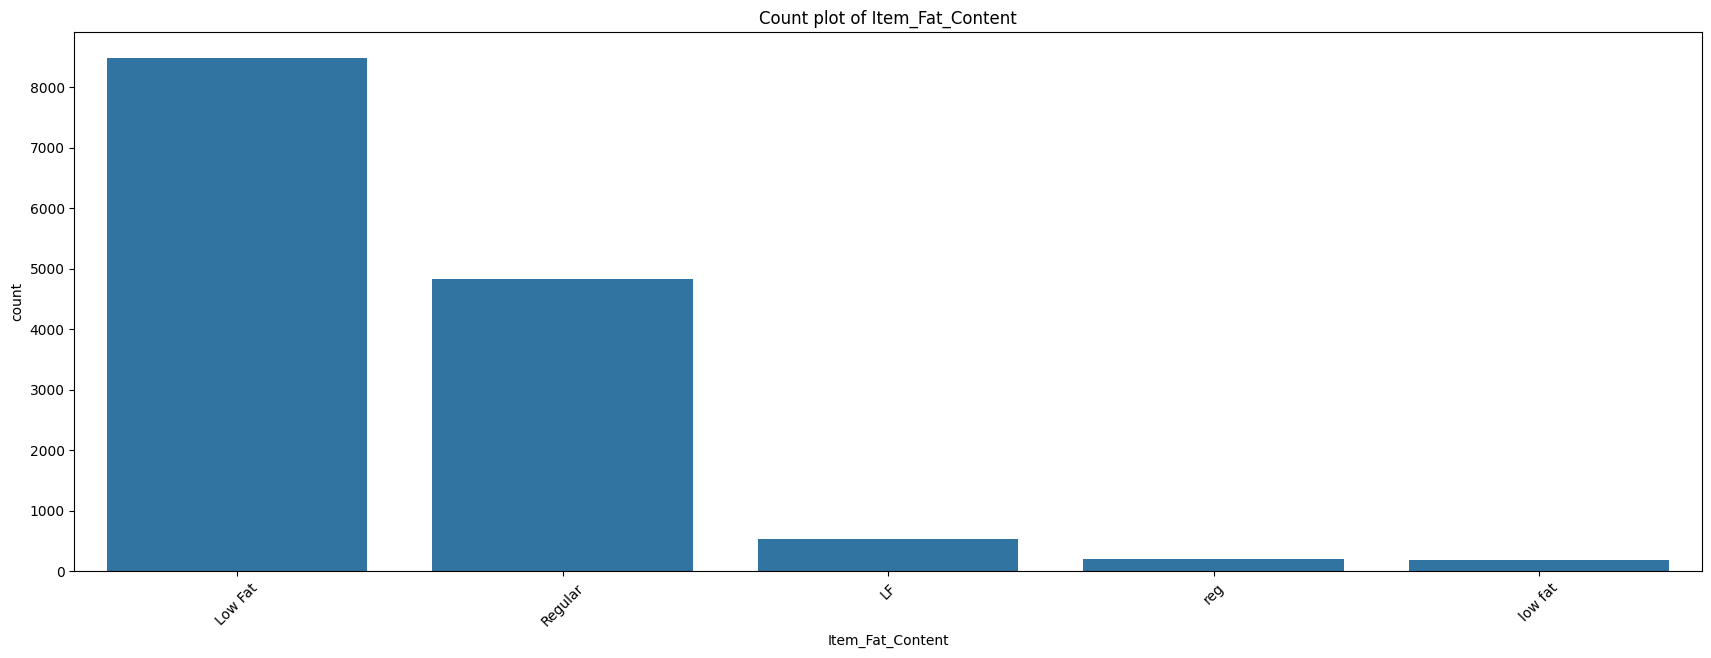

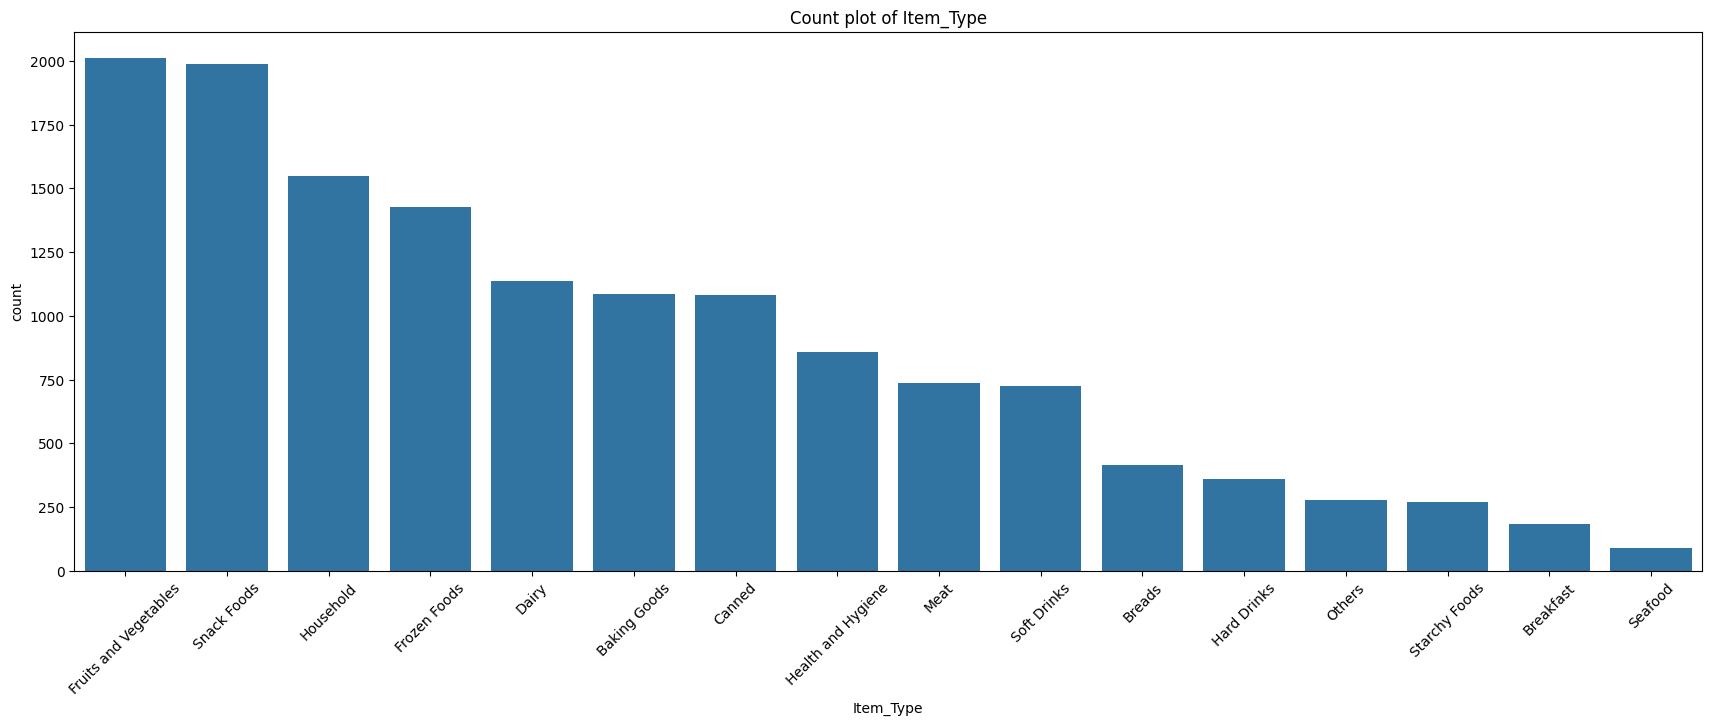

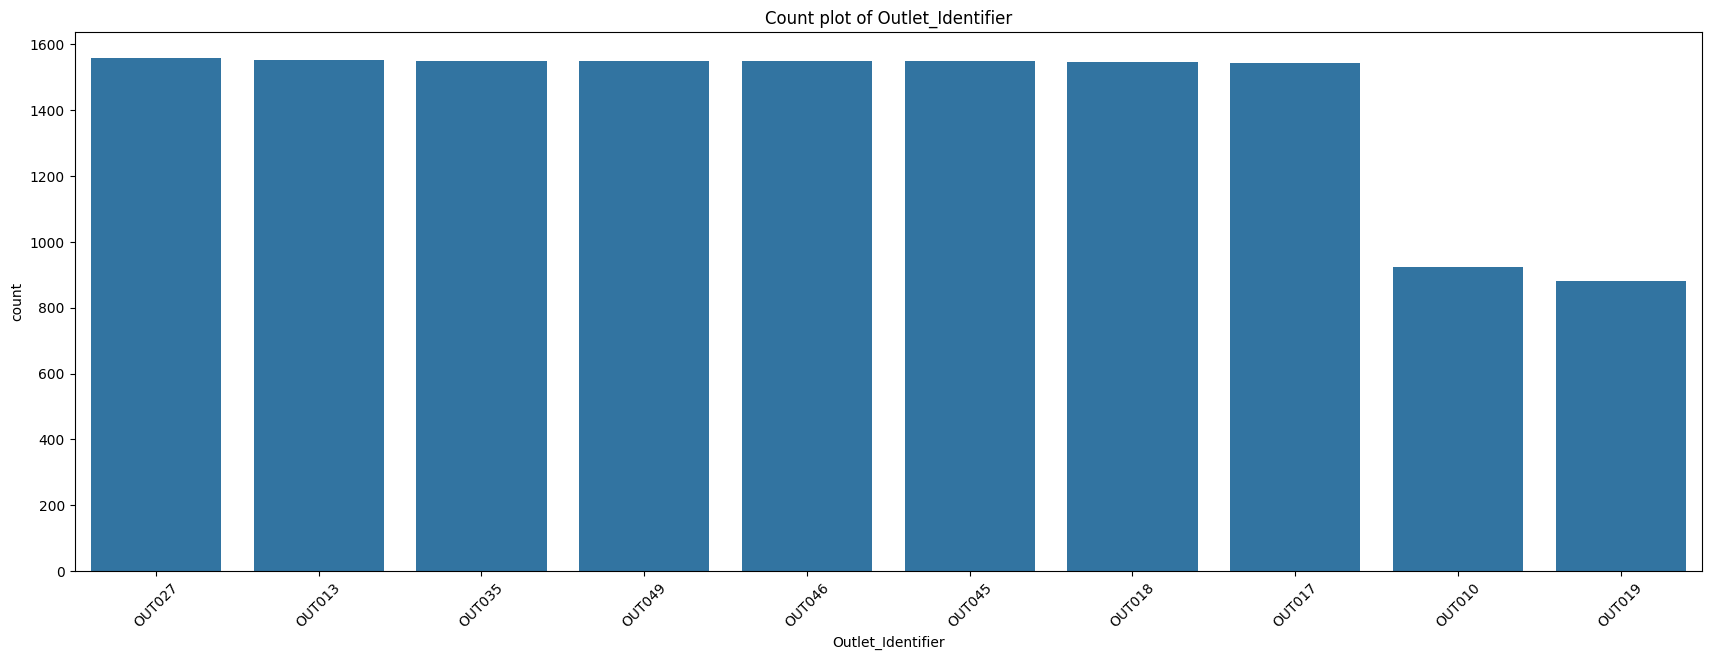

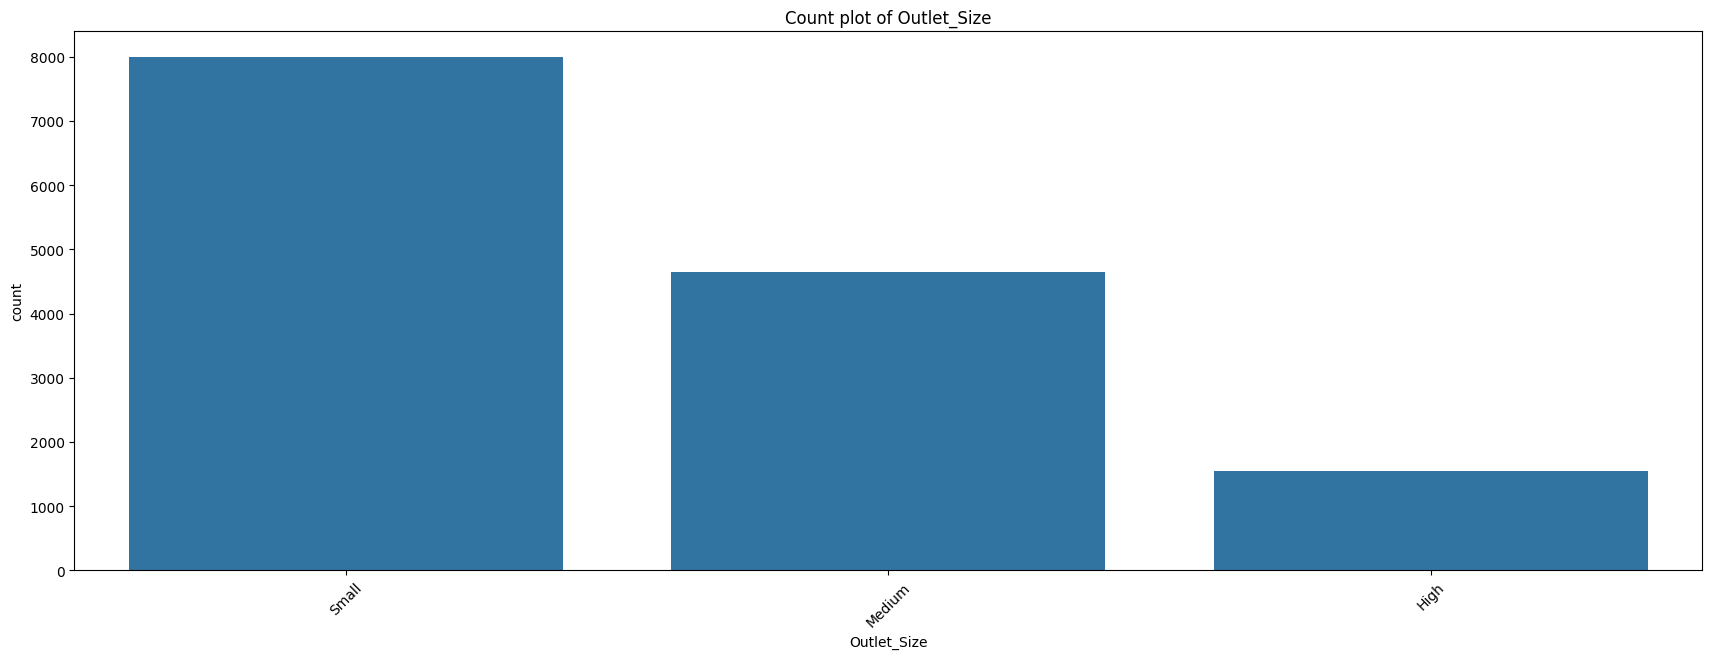

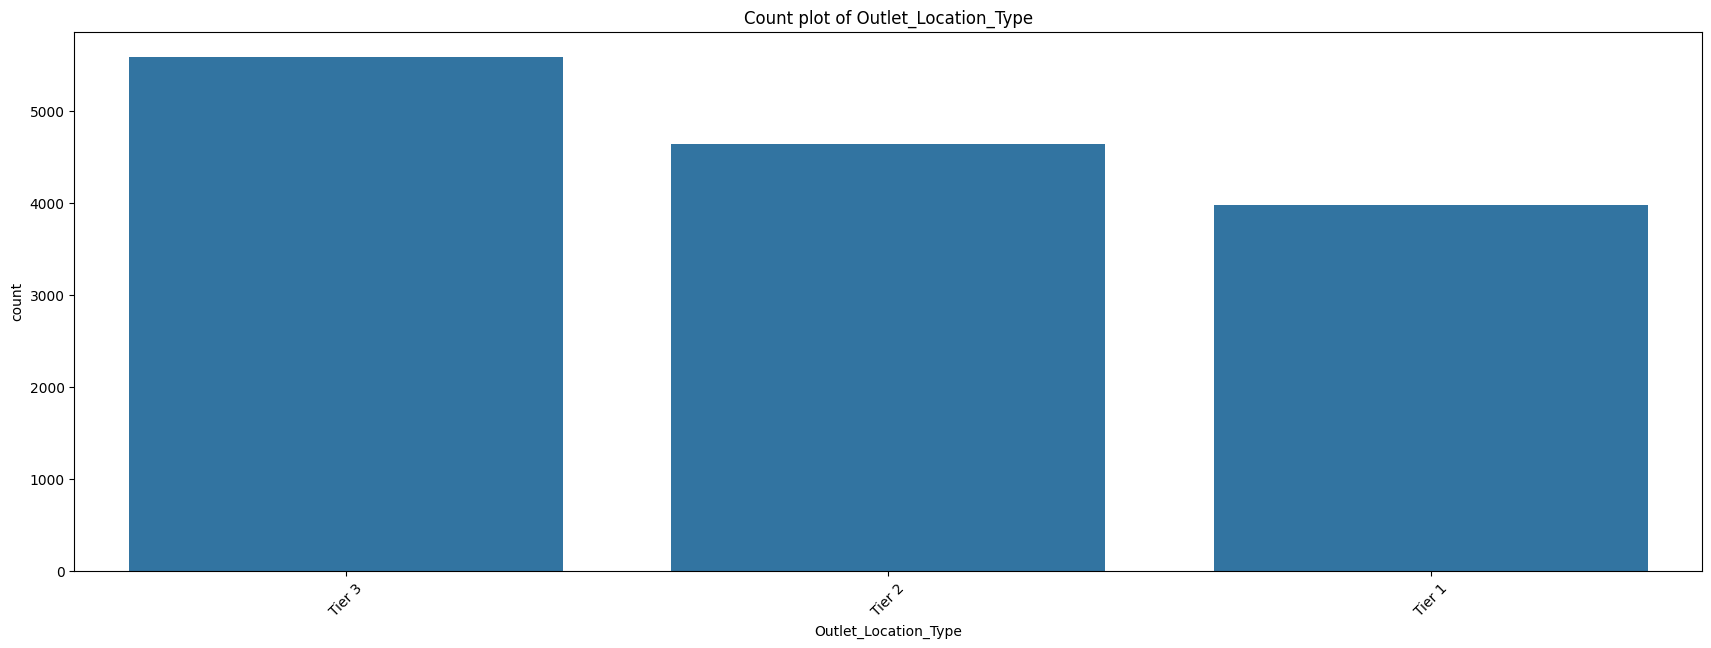

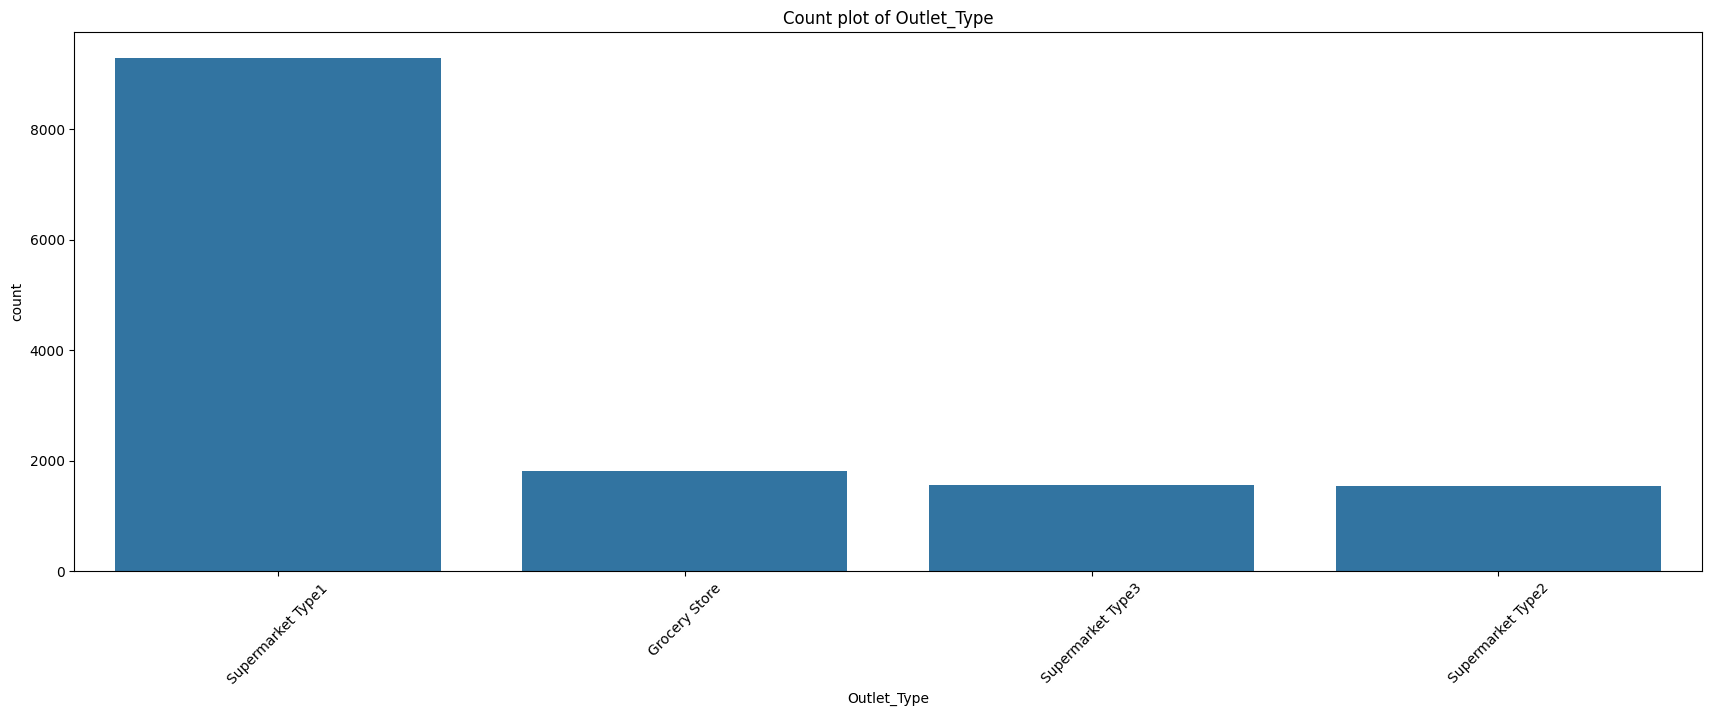

In [39]:
plot_categorical_counts(df, obj_cols)

### Cleaning of Item_Fat_Content

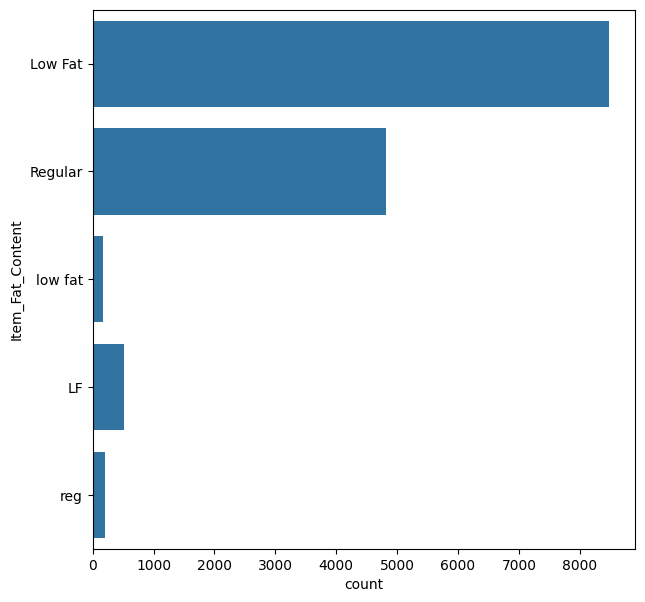

In [40]:
plt.figure(figsize=(7,7))
sns.countplot(df['Item_Fat_Content'])
plt.show()

In [41]:
df.replace({'Item_Fat_Content' : {'low fat' : 'Low Fat' , 'LF' : 'Low Fat' , 'reg' : 'Regular'}}, inplace= True)

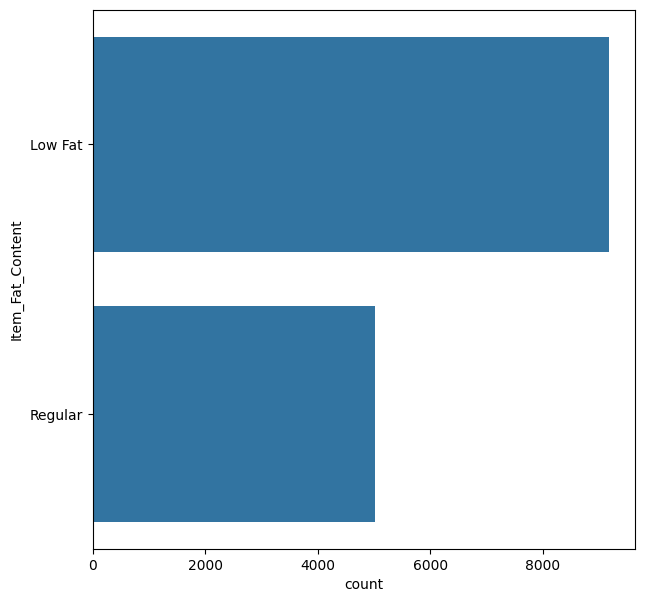

In [42]:
plt.figure(figsize=(7,7))
sns.countplot(df['Item_Fat_Content'])
plt.show()

## Label Encoder

In [43]:
obj_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Source']

In [44]:
encoder = LabelEncoder()

In [45]:
def encoding(obj_cols):
    for i in obj_cols:
        if i != 'Source':
            df[i] = encoder.fit_transform(df[i])

In [46]:
encoding(obj_cols)

In [47]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Source
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,train
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,train
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,train
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,train
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...
14198,233,10.50,1,0.013496,13,141.3154,8,1997,2,0,1,test
14199,308,7.60,1,0.142991,15,169.1448,3,2009,1,2,2,test
14200,1426,10.00,0,0.073529,8,118.7440,7,2002,2,1,1,test
14201,521,15.30,1,0.000000,3,214.6218,2,2007,2,1,1,test


## Separating The Train and Test Dataframes

In [48]:
processed_train = df[df['Source'] == 'train'].drop(columns='Source')
processed_test = df[df['Source'] == 'test'].drop(columns='Source')

In [49]:
processed_test

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8522,1114,20.750000,0,0.007565,13,107.8622,9,1999,1,0,1
8523,1078,8.300000,1,0.038428,4,87.3198,2,2007,2,1,1
8524,1420,14.600000,0,0.099575,11,241.7538,0,1998,2,2,0
8525,817,7.315000,0,0.015388,13,155.0340,2,2007,2,1,1
8526,1197,12.792684,1,0.118599,4,234.2300,5,1985,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...
14198,233,10.500000,1,0.013496,13,141.3154,8,1997,2,0,1
14199,308,7.600000,1,0.142991,15,169.1448,3,2009,1,2,2
14200,1426,10.000000,0,0.073529,8,118.7440,7,2002,2,1,1
14201,521,15.300000,1,0.000000,3,214.6218,2,2007,2,1,1


In [50]:
processed_train['Item_Outlet_Sales'] = target.values

In [51]:
processed_train

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.300,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.920,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.500,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.200,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.930,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8517,389,20.750,1,0.083607,5,178.8318,8,1997,2,0,1,3608.6360
8518,370,6.865,0,0.056783,13,214.5218,1,1987,0,2,1,2778.3834
8519,897,8.380,1,0.046982,0,108.1570,7,2002,2,1,1,549.2850
8520,1357,10.600,0,0.035186,8,85.1224,6,2004,2,1,1,1193.1136


In [52]:
processed_train.drop(columns='Item_Identifier', inplace=True)

## Splitting the Dataset into Training and Testing Sets

In [53]:
X = processed_train.drop(columns = 'Item_Outlet_Sales',axis=1)
y = processed_train['Item_Outlet_Sales']

In [54]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)

## Model Training & Evaluation

In [55]:
results = {}

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"{name} -> R2: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    results[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}
    return r2

In [56]:
models = [
    (LinearRegression(), "Linear Regression"),
    (Ridge(alpha=1.0), "Ridge Regression"),
    (Lasso(alpha=0.01), "Lasso Regression"),
    (RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42), "Random Forest"),
    (GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), "Gradient Boosting"),
    (AdaBoostRegressor(n_estimators=100, learning_rate=0.1, random_state=42), "AdaBoost"),
    (ExtraTreesRegressor(n_estimators=100, max_depth=10, random_state=42), "Extra Trees"),
    (BaggingRegressor(n_estimators=100, random_state=42), "Bagging Regressor"),
    (XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), "XGBoost"),
    (KNeighborsRegressor(n_neighbors=5), "KNN Regressor"),
    (SVR(C=100, kernel='rbf'), "Support Vector Regressor"),
    (CatBoostRegressor(verbose=0, learning_rate=0.1, depth=6), "CatBoost Regressor"),
    (LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42), "LightGBM Regressor"),
    (XGBRegressor(n_estimators=200,learning_rate=0.05,max_depth=5,subsample=0.8,colsample_bytree=0.8,reg_alpha=0.5,reg_lambda=1,random_state=42,verbosity=0), "XGBoost Regressor")
]

In [57]:
for model, name in models:
    evaluate_model(model, name)

Linear Regression -> R2: 0.4987, RMSE: 1203.92, MAE: 895.08
Ridge Regression -> R2: 0.4986, RMSE: 1203.98, MAE: 895.07
Lasso Regression -> R2: 0.4987, RMSE: 1203.92, MAE: 895.08
Random Forest -> R2: 0.5905, RMSE: 1088.12, MAE: 753.28
Gradient Boosting -> R2: 0.5976, RMSE: 1078.68, MAE: 747.30
AdaBoost -> R2: 0.5671, RMSE: 1118.72, MAE: 828.67
Extra Trees -> R2: 0.5999, RMSE: 1075.49, MAE: 740.70
Bagging Regressor -> R2: 0.5606, RMSE: 1127.14, MAE: 786.48
XGBoost -> R2: 0.6008, RMSE: 1074.36, MAE: 742.51
KNN Regressor -> R2: 0.5131, RMSE: 1186.53, MAE: 833.42
Support Vector Regressor -> R2: 0.2155, RMSE: 1506.03, MAE: 1088.17
CatBoost Regressor -> R2: 0.5522, RMSE: 1137.93, MAE: 783.84
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 787
[LightGBM] [Info] Number of data points in the 

In [58]:
results_df = pd.DataFrame(results).T.sort_values(by="R2", ascending=False)
results_df

,R2,RMSE,MAE
XGBoost,0.600787,1074.363160,742.513417
Extra Trees,0.599948,1075.491073,740.695952
Gradient Boosting,0.597570,1078.682792,747.296492
XGBoost Regressor,0.591209,1087.174121,751.653430
Random Forest,0.590499,1088.118356,753.284717
LightGBM Regressor,0.583219,1097.748121,758.120649
AdaBoost,0.567144,1118.717583,828.670140
Bagging Regressor,0.560605,1127.136182,786.478339
CatBoost Regressor,0.552152,1137.925141,783.837439
KNN Regressor,0.513079,1186.527336,833.423604


## Hyper-Parameter Tuning

In [59]:
xgb = XGBRegressor(random_state=42)

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

xgb_search = RandomizedSearchCV(xgb, param_distributions=xgb_params,n_iter=30, scoring='r2',cv=3, verbose=1, n_jobs=-1)
xgb_search.fit(X_train, y_train)

print("Best XGBoost Params:", xgb_search.best_params_)
print("Best R² Score:", xgb_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best XGBoost Params: {'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best R² Score: 0.5963134656556476


In [60]:
et = ExtraTreesRegressor(random_state=42)

et_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

et_search = RandomizedSearchCV(et, param_distributions=et_params,n_iter=30, scoring='r2',cv=3, verbose=1, n_jobs=-1)
et_search.fit(X_train, y_train)

print("Best Extra Trees Params:", et_search.best_params_)
print("Best R² Score:", et_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Extra Trees Params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Best R² Score: 0.5833209137201096


In [61]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbr_search = RandomizedSearchCV(gbr, param_distributions=gbr_params,n_iter=30, scoring='r2',cv=3, verbose=1, n_jobs=-1)
gbr_search.fit(X_train, y_train)

print("Best Gradient Boosting Params:", gbr_search.best_params_)
print("Best R² Score:", gbr_search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Gradient Boosting Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.05}
Best R² Score: 0.5973025583432244


In [62]:
evaluate_model(xgb_search.best_estimator_, "XGBoost Tuned")
evaluate_model(et_search.best_estimator_, "Extra Trees Tuned")
evaluate_model(gbr_search.best_estimator_, "Gradient Boosting Tuned")

XGBoost Tuned -> R2: 0.6042, RMSE: 1069.72, MAE: 745.62
Extra Trees Tuned -> R2: 0.6008, RMSE: 1074.37, MAE: 750.50
Gradient Boosting Tuned -> R2: 0.6028, RMSE: 1071.60, MAE: 744.36


0.6028360823512388

## Voting Regressor

In [63]:
best_xgb = xgb_search.best_estimator_
best_gbr = gbr_search.best_estimator_
best_et = et_search.best_estimator_

voting_reg = VotingRegressor(
    estimators=[
        ('xgb', best_xgb),
        ('gbr', best_gbr),
        ('et', best_et)
    ],
    weights=[0.3, 0.4, 0.3]
)

voting_reg.fit(X_train, y_train)

evaluate_model(voting_reg, "Voting Regressor")

Voting Regressor -> R2: 0.6064, RMSE: 1066.79, MAE: 742.48


0.6063983979328902

## Model Comparison

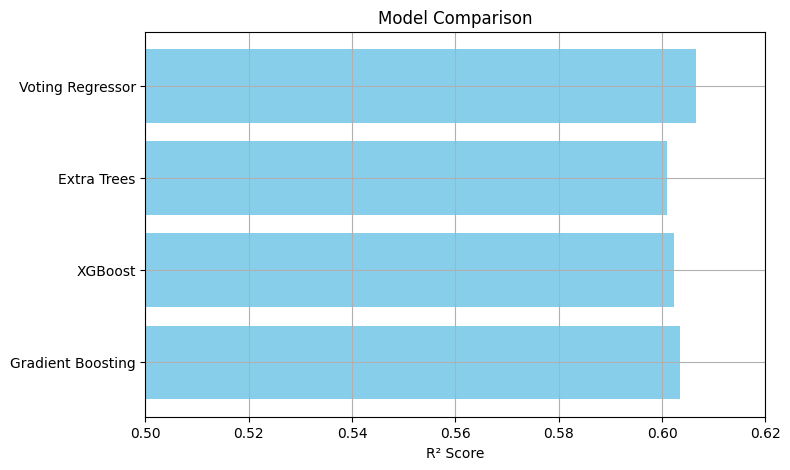

In [64]:
model_scores = {
    "Gradient Boosting": 0.6035,
    "XGBoost": 0.6022,
    "Extra Trees": 0.6009,
    "Voting Regressor": 0.6066
}

plt.figure(figsize=(8, 5))
plt.barh(list(model_scores.keys()), list(model_scores.values()), color='skyblue')
plt.xlabel("R² Score")
plt.title("Model Comparison")
plt.xlim(0.5, 0.62)
plt.grid(True)
plt.show()

## Saving the Model and Encoder as Binary Files

In [65]:
joblib.dump(voting_reg, "voting_model.pkl")

['voting_model.pkl']

In [66]:
joblib.dump(encoder,"Encoder.pkl")

['Encoder.pkl']

## Author : Anshuman Dash